# Distinguishing muffins and Chihuahuas with NNs

The aim of this project is to train a neural network for the binary classification of muffins and Chihuahuas based on the images contained in the relative [Kaggle dataset](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).

# Setup

In [1]:
import importlib
import os

def import_or_install(package_name, alias=None):
    try:
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} is already installed.")
    except ImportError:
        import subprocess
        print(f"{package_name} is not installed. Installing...")
        subprocess.check_call(['pip', 'install', package_name])
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} has been installed.")

FOLDERNAME = "muffin-vs-chihuahua-image-classification"
PATH = "./"

We import the dataset from Kaggle, using a token.

In [2]:
os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"

import_or_install("kaggle")

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.dataset_download_files("samuelcortinhas/muffin-vs-chihuahua-image-classification", PATH)

kaggle is already installed.


In [3]:
import zipfile

with zipfile.ZipFile(PATH + FOLDERNAME + ".zip", 'r') as zip_ref:
    zip_ref.extractall(FOLDERNAME)
os.remove(PATH + FOLDERNAME +".zip")

If already present we import, or otherwise we install, the `tensorflow` package. Above all functionalities we will be using the `keras` module to construct neural networks to distinguish the images in the dataset.

In [4]:
import_or_install("tensorflow","tf")
from tensorflow import keras

c:\Users\lucia\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


tensorflow is already installed.


# Data pre-processing

Before proceeding we remove badly encoded images.

In [5]:
from PIL import Image
def remove_badly_encoded_images(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.JPG'):
            try:
                img = Image.open(directory+filename)  # open the image file
                img.verify()  # verify that it is, in fact an image
                img.close()
            except (IOError, SyntaxError):
                os.remove(directory+filename)

deleted = remove_badly_encoded_images(PATH + FOLDERNAME + "/")
print("Deleted images:",deleted)

Deleted images: None


We begin by subdividing the dataset into training and test set. This partition is provided by the Kaggle dataset itself, with $\frac{1}{5}$ of the images assigned to the test set.

We also infer the binary labels from the layout of the dataset. Specifically the labels are assigned as follows:
\begin{equation*}
    \begin{cases}
        0  & \text{chihuahua} \\
        1  & \text{muffin}
    \end{cases}
\end{equation*}

In [6]:
def create_dataset(foldername):
    dataset_path = os.path.join(PATH, FOLDERNAME, foldername)
    return keras.utils.image_dataset_from_directory(dataset_path, labels = "inferred")

print("Training set:")
train_ds = create_dataset("train")
print("Test set")
test_ds = create_dataset("test")

Training set:
Found 4733 files belonging to 2 classes.
Test set
Found 1184 files belonging to 2 classes.


Let's give a look at a small sample of pictures with the relative annotations.

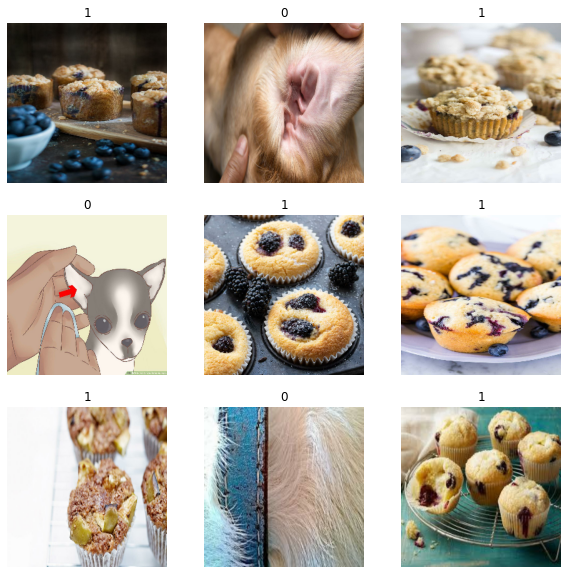

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Before diving into the actual pre-processing of the data we prepare a function that produces realistic variations of the images in the dataset. This data augmentation step is useful to make a small dataset more expressive by introducing random changes, so counteracting overfitting.

In [8]:
from keras import layers

def data_augmentation(images, data_augmentation_layers, training = True):
    for layer in data_augmentation_layers:
        images = layer(images, training = training)
    return images

For example we may randomly flip the picture or slightly tilt it. We show here the potential results of the data augmentation function.

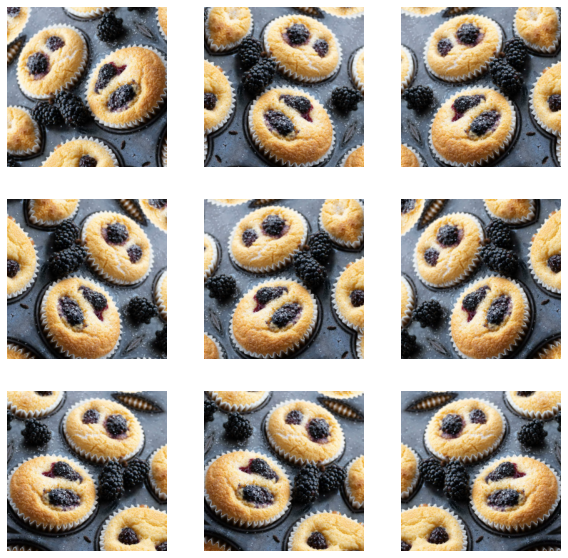

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
]

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, data_augmentation_layers, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

To make learning easer we simplify the images by:
* taking them in grayscale,
* reducing their dimensions by resizing them to the size $(64,64)$.

In [10]:
def rgb_to_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image

def resize_image(image, target_size):
    resized_image = tf.image.resize(image, target_size)
    return resized_image


image_size = (64,64)

preprocess = {
    'rgb_to_grayscale': lambda x, y: (rgb_to_grayscale(x),y),
    'resize_image': lambda x,y: (resize_image(x, image_size),y)
}

for func_name, func in preprocess.items():
    train_ds = train_ds.map(func)
    test_ds = test_ds.map(func)

Also, for the reasons stated before, we substitute each of the images in the training set with it's augmented version.

In [11]:
import math

def augment_dataset(dataset, data_augmentation_function, fraction):
    n_images = math.ceil(dataset.cardinality().numpy()*fraction)
    augmented_images = dataset.take(n_images).map(lambda x,y: (data_augmentation_function(x),y))
    return dataset.concatenate(augmented_images)

train_ds_augmented = augment_dataset(train_ds, lambda x: data_augmentation(x, data_augmentation_layers), 0.3)

In [12]:
(train_ds.cardinality().numpy(), train_ds_augmented.cardinality().numpy())

(148, 193)

# Model construction

To try and classify the images in the dataset we build various neural network models, and store them in the `models_configs` dictionary. For the moment we prepare the structure of each neural network, and other parameters, like `optimizer`, `loss` and `metrics`, that will be needed to build (compile) the models.

Also, instead of fixing the values that characterize the layers of the models, we have used hyperparameters placeholders. We have opted for an object of type `HyperParameter`, that allows to specify the type and domain for the desired value. These parameters will be tuned in a later step.

In the next sections we display the classes for each of the hypermodels, and the relative visual representation of the sequential layers.

In [13]:
input_shape = train_ds.element_spec[0].shape[1:]

import_or_install("pydot")
def display_hypermodel(hypermodel_class, hypermodel_name):
    hypermodel = hypermodel_class(input_shape)
    built_hypermodel = hypermodel.build(kt.HyperParameters())
    return keras.utils.plot_model(built_hypermodel, to_file=hypermodel_name +'.png', show_layer_names=True)

pydot is already installed.


In [14]:
import_or_install("keras_tuner","kt")

keras_tuner is already installed.


## Hypermodel 1

In [15]:
class HyperModel_1(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Flatten(name='flatten'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

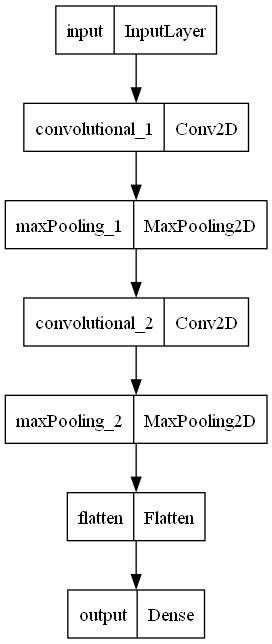

In [16]:
display_hypermodel(HyperModel_1, 'hypermodel_1')

The first, simpler model, is composed by two convolutional layers, ideal for detecting patterns in images. Also, each of the convolutional layers is followed by max pooling layers, with the aim of summarizing the information extracted by passing a kernel over the images multiple times, as prescribe by the `filters` parameter.

After the first feature learning stage follows a dense layer, to connect the patterns found in the images to the desired output. Finally, the last output layer is designed to summarize this information into a unique value in the interval $\left[0,1\right]$.

In [17]:
class HyperModel_2(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Flatten(name='flatten'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

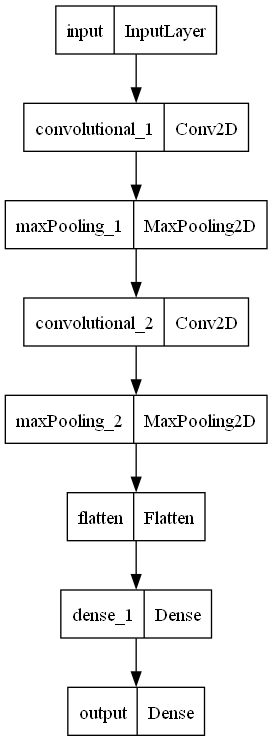

In [18]:
display_hypermodel(HyperModel_2,'hypermodel_2')

## Hypermodel 3

In [19]:
class HyperModel_3(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=self.input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Conv2D(hp.Choice('filters_3', [16, 32, 64]), np.array(hp.Choice('kernel_size_3', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_3'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_3', range(2, 5))).repeat(2), name='maxPooling_3'),
            layers.Flatten(name='flatten'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

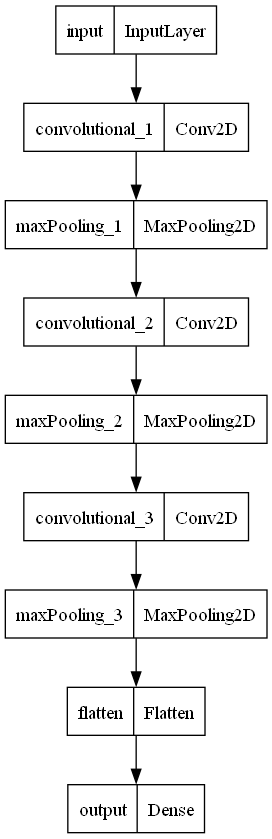

In [20]:
display_hypermodel(HyperModel_3, 'hypermodel_3')

For this model we wanted to study the quality of the prediction obtained by adding an additional pair of convolutional and max pooling layers.

## Hypermodel 4

In [21]:
class HyperModel_4(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=self.input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Conv2D(hp.Choice('filters_3', [16, 32, 64]), np.array(hp.Choice('kernel_size_3', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_3'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_3', range(2, 5))).repeat(2), name='maxPooling_3'),
            layers.Flatten(name='flatten'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

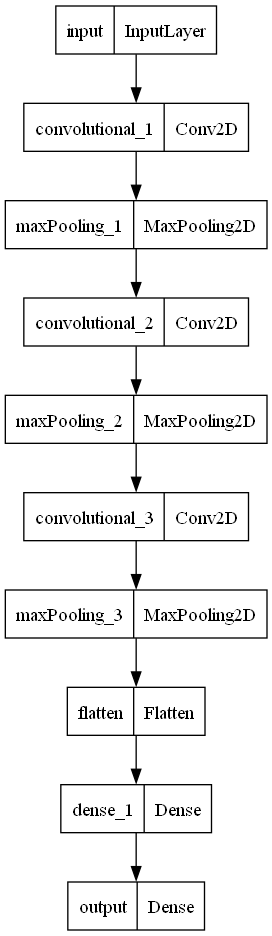

In [22]:
display_hypermodel(HyperModel_4, 'hypermodel_4')

Lastly, we were curious to see the effect of inserting a flattening layer between extracting image features and relating such patterns to the classification problem. By flattening the results of the convolutional networks we are reducing the expressivity of the foundings, but we are also simplifying the task left for the two last layers.

## Hyperparameter tuning

Now that we have outlined the structure of the neural networks we choose the hyperparameters for each layer. Specifically we are looking to valorize the following parameters:
* convolutional layers (type `Conv2D`)
    * number of filters
    * size of the kernels, square in shape
* max pooling layers (type `MaxPooling2D`)
    * size of the pool
* dense layers that are no output layers (type `Dense`)
    * number of
    
To do this we use the `keras_tune` library {cite}`omalley2019kerastuner`, that allows hyperparameter tuning. It allows to build a `Tuner` object based on a compiled Keras model that has as argument a `Hyperparameter` object. Such a tuner can then search for the best possible hyperparameters for the model and value domains that have been supplied. For efficiency reasons we have opted for a random search in the hyperparameter space, in fact we have set the `max_trials` option such that only a portion of the combinations of hyperparameters will be evaluated.   
The tuner also acts as a log for the hyperparameter combinations that have ben tested, that will become useful in the experiment section.

If present, the prepared tuners are loaded from the *tuners* directory.

In [23]:
hypermodels = {
    'hypermodel_1': HyperModel_1,
    'hypermodel_2': HyperModel_2,
    'hypermodel_3': HyperModel_3,
    'hypermodel_4': HyperModel_4
}

In [24]:
def tune_hypermodel(model_name, model_class, train_ds, test_ds, directory, max_trials):
    tuner = kt.RandomSearch(
        model_class(input_shape),
        objective = 'val_accuracy',
        directory = directory,
        max_trials = max_trials,
        project_name = model_name)

    tuner.search(train_ds, epochs = 10, validation_data = test_ds)

    return tuner

In [25]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
tuners = {}
for hypermodel_name, hypermodel_class in hypermodels.items():
    with tf.device('/device:GPU:0'):
        tuners[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, train_ds, test_ds, 'tuners', 10)

Reloading Tuner from tuners\hypermodel_1\tuner0.json


Reloading Tuner from tuners\hypermodel_2\tuner0.json
Reloading Tuner from tuners\hypermodel_3\tuner0.json
Reloading Tuner from tuners\hypermodel_4\tuner0.json


Let's give a look at the best hyperparameter values that the tuners have found for the hypermodels with respect to the loss that the model produces.

In [27]:
import_or_install("pandas","pd")

def tuners_get_best_hyperparameters(tuners, hypermodels):
    best_hps = {}
    for hypermodel_name in hypermodels:
        best_hps[hypermodel_name] = tuners[hypermodel_name].get_best_hyperparameters()[0]
    return best_hps   
        
def tuners_display_best_hyperparameters(tuners, hypermodels):
    best_hps = tuners_get_best_hyperparameters(tuners, hypermodels)
    best_hps_values = {k: v.values for k, v in best_hps.items()}
    print(pd.DataFrame.from_dict(best_hps_values).fillna("-"))

pandas is already installed.


In [28]:
tuners_display_best_hyperparameters(tuners, hypermodels)

              hypermodel_1 hypermodel_2 hypermodel_3  hypermodel_4
filters_1             64.0         64.0         16.0            32
kernel_size_1          4.0          4.0          4.0             4
pool_size_1            4.0          4.0          2.0             3
filters_2             64.0         64.0         64.0            64
kernel_size_2          4.0          4.0          3.0             3
pool_size_2            3.0          3.0          3.0             4
units                    -         32.0            -            64
filters_3                -            -         64.0            64
kernel_size_3            -            -          5.0             5
pool_size_3              -            -          3.0             4


And here are the losses with respect to binary cross entropy that have been computed respectively for each of the models with the best hyperparameters.

In [29]:
def tuners_display_metrics(tuners, hypermodels):
    best_metrics = {}
    for hypermodel_name in hypermodels:
        best_metrics[hypermodel_name] = tuners[hypermodel_name].oracle.get_best_trials(1)[0].score
    print(pd.DataFrame({ k:[v] for (k,v) in best_metrics.items()}, index = ["loss"]))

In [30]:
tuners_display_metrics(tuners, hypermodels)

      hypermodel_1  hypermodel_2  hypermodel_3  hypermodel_4
loss      0.827703      0.841216      0.852196      0.847973


We now repeat this procedure for the augmented training set. By adding images obtained by randomly modifying the ones already present in the dataset we should avoid overfitting. So we suppose that for the models obtained through these hyperparameters the risk will be less.

In [31]:
hypermodels = {
    'hypermodel_1': HyperModel_1,
    'hypermodel_2': HyperModel_2,
    'hypermodel_3': HyperModel_3,
    'hypermodel_4': HyperModel_4
}

In [32]:
# tuners_augmented = {}
# for hypermodel_name, hypermodel_class in hypermodels.items():
#     with tf.device('/GPU:0'):
#         tuners[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, train_ds_augmented, test_ds, 'tuners_augmented', 100)

In [33]:
# tuners_display_best_hyperparameters(tuners_augmented, hypermodels)

In [34]:
# tuners_display_metrics(tuners_augmented, hypermodels)

Now that we have found a collection of good hyperparameters, we build the resulting models, that will serve as a starting point for the evaluation of the quality of the models. We do this for the hyperparameters extracted by using the original training set and the augmented version.

In [35]:
def get_best_models(tuners, hypermodels):
    best_model = {}
    best_hps = tuners_get_best_hyperparameters(tuners, hypermodels)
    for hypermodel_name, hypermodel_class in hypermodels.items():
        hps = best_hps[hypermodel_name]
        model = hypermodel_class(input_shape)
        best_model[hypermodel_name[5:]] = model.build(hps)
    return best_model

In [36]:
best_models = get_best_models(tuners, hypermodels)
best_models_augmented = get_best_models(tuners_augmented, hypermodels)

# Evaluation

We will evaluate the various neural networks according to their risk with zero-one loss. We will estimate such measure using $5$-fold cross validation.

In [43]:
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold


def fold_validation(model, X, y, train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    with tf.device('/GPU:0'):
        model.fit(X_train, y_train)
    
    predicted_labels_continuous = model.predict(X_test)
    predicted_labels = [round(l[0]) for l in predicted_labels_continuous]
    loss = zero_one_loss(y_test, predicted_labels)
    return loss

def cross_validation(model, X, y, num_folds):
    kf = KFold(n_splits=num_folds)
    
    losses = [0]*num_folds
    for i,(train_index, test_index) in enumerate(kf.split(X)):
        losses[i] = fold_validation(model, X, y, train_index, test_index)
        
    return losses
      

We first of all look at the risk approximation for the best model we have found for each of the hypermodels. These values are a reference to discuss the best performing hypermodel, and to try and motivate why the tuner had settled for the chosen hyperparameters.

In [53]:
import json

class LossesJson:
    def __init__(self, filename):
        self.filename = filename
        self.losses = {}
        
    def __str__(self):        
        aesthetic_dict = {
            model: {
                    **model_data["loss_folds"],
                    "loss_cv": model_data["loss_cv"]
                }
            for model, model_data in self.losses.items()
        }
        return str(pd.DataFrame.from_dict(aesthetic_dict))
    

    def update(self, model_name, losses):
        def losses_to_dict(loss_cv, loss_folds):
            losses_dict = {}
            num_folds = len(loss_folds)
            losses_dict["loss_folds"] = {}
            for fold in range(num_folds):
                fold_name =  f"fold_{fold+1}"
                losses_dict["loss_folds"][fold_name] = loss_folds[fold]
            losses_dict["loss_cv"] = loss_cv
            return losses_dict
        
        self.losses[model_name] = losses_to_dict(np.mean(losses), losses)
        self.save()

    def save(self):
        with open(self.filename, 'w') as file:
            json.dump(self.losses, file, indent = 4)

    def load(self):
        with open(self.filename, 'r') as file:
            self.losses = json.load(file)
            
    def get_losses(self):
        self.load()
        return self.losses


With the `use_prepared_losses` variable set to `True`, the precomputed losses, referred to the models obtained by setting the hyperparameters shown above, are loaded from the *losses* json array.

In [54]:
from os.path import exists
from multiprocessing import Pool

def save_execute_cross_validation_on_models(filename, models, X,y, num_folds):
    
    losses_json = LossesJson(filename)
    
    if exists(filename):
        losses_json.load()
    
    models_without_losses = dict(models)
    for key in losses_json.get_losses():
        models_without_losses.pop(key)
    
    if len(models_without_losses):        
        for model_name, model_class in models_without_losses.items():
            print(f"Cross_validation for model: {model_name}")
            losses = cross_validation(model_class, X,y, num_folds)
            print(f"Losses: {losses}")
            print(f"Cross validation loss: {np.mean(losses)}")
            losses_json.update(model_name, losses)
    
    return losses_json

In [55]:
def dataset_to_numpy_arrays(dataset):     
    X = []
    y = []
    for features, labels in dataset:
        X.append(features.numpy())
        y.append(labels.numpy())
    X = np.array(X)
    y = np.array(y)
    return X,y

dataset = train_ds.concatenate(test_ds).unbatch()
X,y = dataset_to_numpy_arrays(dataset)

Cross_validation for model: model_4
37/37 [==============================] - 1s 14ms/step
Losses: [0.0380067567567568, 0.060810810810810856, 0.03381234150464918, 0.026204564666103103, 0.017751479289940808]
Cross validation loss: 0.03531719060565215
          model_1   model_2   model_3   model_4
fold_1   0.042969  0.539062  0.429688  0.038007
fold_2   0.050781  0.355469  0.328125  0.060811
fold_3   0.019531  0.218750  0.261719  0.033812
fold_4   0.007812  0.246094  0.191406  0.026205
loss_cv  0.027969  0.318125  0.278438  0.035317
fold_5        NaN       NaN       NaN  0.017751


In [ ]:
losses_json_best_models = save_execute_cross_validation_on_models("losses.json", best_models, X, y, 5)
print(losses_json_best_models)

In [ ]:
save_execute_cross_validation_on_models("losses_augmented.json", best_models_augmented, train_ds, test_ds, 5)
print(losses_json_best_models)